https://towardsdatascience.com/ab-testing-with-python-e5964dd66143

In [1]:
ls

 Volume in drive C has no label.
 Volume Serial Number is BCC0-49D8

 Directory of C:\Users\KonuTech\DataSpellProjects\AB_testing

12.04.2022  00:18    <DIR>          .
12.04.2022  00:18    <DIR>          ..
11.04.2022  21:53    <DIR>          .idea
11.04.2022  22:48    <DIR>          .ipynb_checkpoints
01.10.2019  20:25        15˙901˙933 ab_data.csv
12.04.2022  00:18            54˙728 AB_testing.ipynb
11.04.2022  22:49         4˙234˙322 archive (3).zip
               3 File(s)     20˙190˙983 bytes
               4 Dir(s)  88˙629˙444˙608 bytes free


In [2]:
!pip install --disable-pip-version-check -q numpy
!pip install --disable-pip-version-check -q pandas
!pip install --disable-pip-version-check -q scipy
!pip install --disable-pip-version-check -q statsmodels
!pip install --disable-pip-version-check -q matplotlib
!pip install --disable-pip-version-check -q seaborn

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sm
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random

In [4]:
%matplotlib inline

In [5]:
# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {
    'family': 'Helvetica',
    'weight': 'bold',
    'size': 13
}

In [6]:
mpl.rc('font', **font)

In [7]:
# Calculating effect size based on our expected rates
effect_size = sm.proportion_effectsize(0.13, 0.15)
power=random.uniform(0.8, 0.9)
alpha=0.05
ratio=1

In [8]:
# Calculating sample size needed
required_n = sm.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=ratio
)

In [9]:
# Rounding up to next whole number
required_n = ceil(required_n)

In [10]:
print(power)
print(required_n)

0.8539703773656246
5461


In [11]:
df = pd.read_csv('ab_data.csv')

In [12]:
df.shape

(294478, 5)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
df.sample(5)

,user_id,timestamp,group,landing_page,converted
142656,914499,2017-01-22 02:54:12.801296,treatment,new_page,0
51757,664662,2017-01-18 15:30:22.826995,treatment,new_page,0
96371,819543,2017-01-22 10:37:33.969177,treatment,new_page,0
10639,663619,2017-01-05 08:24:16.635145,control,new_page,0
28231,687320,2017-01-23 06:19:21.509594,control,old_page,0


In [15]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [16]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [17]:
session_counts = df['user_id'].value_counts(ascending=False)

In [18]:
session_counts

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

In [19]:
multi_users = session_counts[session_counts > 1].count()

In [20]:
multi_users

3894

In [21]:
users_to_drop = session_counts[session_counts > 1].index

In [22]:
users_to_drop

Int64Index([805339, 754884, 722274, 783176, 898232, 899018, 904570, 842042,
            881123, 858720,
            ...
            721188, 902463, 713355, 827417, 655283, 847058, 889392, 664150,
            835401, 736955],
           dtype='int64', length=3894)

In [23]:
df = df[~df['user_id'].isin(users_to_drop)]

In [24]:
df.shape

(286690, 5)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


In [26]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)

In [27]:
control_sample.shape

(5461, 5)

In [28]:
control_sample.sample(3)

,user_id,timestamp,group,landing_page,converted
283819,630929,2017-01-16 12:01:15.296046,control,old_page,0
97912,659805,2017-01-02 20:39:54.591443,control,old_page,0
84734,900372,2017-01-11 23:08:06.338570,control,old_page,0


In [29]:
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

In [30]:
treatment_sample.sample(3)

,user_id,timestamp,group,landing_page,converted
119099,737748,2017-01-06 01:19:10.033284,treatment,new_page,0
60987,850686,2017-01-07 12:10:26.036930,treatment,new_page,1
265603,882661,2017-01-22 09:15:38.019167,treatment,new_page,0


In [31]:
ab_test = pd.concat(
    [
        control_sample,
        treatment_sample
    ],
    axis=0
)

In [32]:
ab_test.reset_index(drop=True, inplace=True)

In [33]:
ab_test.sample(3)

,user_id,timestamp,group,landing_page,converted
4417,715459,2017-01-17 10:50:57.775569,control,old_page,1
2406,935590,2017-01-06 00:40:37.017840,control,old_page,0
1406,919526,2017-01-10 23:39:45.966272,control,old_page,0


In [34]:
ab_test['group'].value_counts()

control      5461
treatment    5461
Name: group, dtype: int64

In [35]:
conversion_rates = ab_test.groupby('group')['converted']

In [36]:
conversion_rates

In [37]:
# Standard deviation of the proportion
std_p = lambda x: np.std(x, ddof=0)

In [38]:
# Standard error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x , ddof=0)

In [39]:
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

In [40]:
conversion_rates

,conversion_rate,std_deviation,std_error
group,,,
control,0.119575,0.324464,0.004391
treatment,0.126534,0.332450,0.004499


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


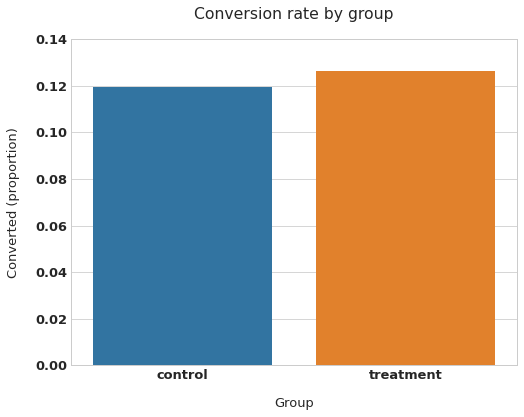

In [41]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.14)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [42]:
control_results = ab_test[ab_test['group'] == 'control']['converted']

In [43]:
control_results

0       0
1       0
2       0
3       0
4       0
       ..
5456    0
5457    0
5458    0
5459    0
5460    0
Name: converted, Length: 5461, dtype: int64

In [44]:
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [45]:
treatment_results

5461     0
5462     0
5463     0
5464     0
5465     0
        ..
10917    0
10918    0
10919    0
10920    0
10921    0
Name: converted, Length: 5461, dtype: int64

In [46]:
n_con = control_results.count()

In [47]:
n_treat = treatment_results.count()

In [48]:
successes = [control_results.sum(), treatment_results.sum()]

In [49]:
nobs = [n_con, n_treat]

In [50]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)

In [51]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [52]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -1.11
p-value: 0.268
ci 95% for control group [0.111, 0.128]
ci 95% for treatment group [0.118, 0.135]
